In [1]:
import pandas as pd
import numpy as np

In [2]:
df= pd.read_csv('event_preferences.csv')

In [3]:
df.head()

,Department,Event_Type,Time_Preference,Format,Interest,Target_Event
0,BCE,Workshop,Morning,In-person,Skill-building,Tech Workshop
1,BCE,Seminar,Afternoon,Virtual,Inspiration,Guest Lecture Series
2,BCE,Social,Evening,In-person,Networking,Social Mixer
3,BCE,Hackathon,Afternoon,Hybrid,Skill-building,Hackathon
4,BCE,Guest Lecture,Evening,Virtual,Career Development,Career Talk


In [4]:
df.shape

(150, 6)

In [5]:
df['Target_Event'].value_counts()

Target_Event
Tech Workshop           30
Guest Lecture Series    30
Social Mixer            30
Hackathon               30
Career Talk             30
Name: count, dtype: int64

In [6]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.strip().str.title()

In [7]:
df.head()

,Department,Event_Type,Time_Preference,Format,Interest,Target_Event
0,Bce,Workshop,Morning,In-Person,Skill-Building,Tech Workshop
1,Bce,Seminar,Afternoon,Virtual,Inspiration,Guest Lecture Series
2,Bce,Social,Evening,In-Person,Networking,Social Mixer
3,Bce,Hackathon,Afternoon,Hybrid,Skill-Building,Hackathon
4,Bce,Guest Lecture,Evening,Virtual,Career Development,Career Talk


In [8]:
departments = df['Department'].unique()

In [9]:
import os

model_dir = 'dept_models'
os.makedirs(model_dir, exist_ok=True)

In [10]:
departments

array(['Bce', 'Bca', 'Bct', 'Bei', 'Bel'], dtype=object)

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
import pickle

for dept in departments:
    df_dept = df[df['Department'] == dept].copy()
    df_dept = df_dept.drop(columns=['Department'])  

    label_encoders = {}
    for col in df_dept.columns:
        le = LabelEncoder()
        df_dept[col] = le.fit_transform(df_dept[col])
        label_encoders[col] = le

    X = df_dept.drop('Target_Event', axis=1)
    y = df_dept['Target_Event']

    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X, y)

    with open(f'{model_dir}/clf_{dept}.pkl', 'wb') as f:
        pickle.dump(clf, f)
    with open(f'{model_dir}/encoders_{dept}.pkl', 'wb') as f:
        pickle.dump(label_encoders, f)

    print(f"Saved model and encoders for department: {dept}")

Saved model and encoders for department: Bce
Saved model and encoders for department: Bca
Saved model and encoders for department: Bct
Saved model and encoders for department: Bei
Saved model and encoders for department: Bel


In [ ]:
import pickle
import pandas as pd

model_dir = 'dept_models'

dept = input("Enter Department: ").strip().title()

try:
    with open(f'{model_dir}/clf_{dept}.pkl', 'rb') as f:
        clf = pickle.load(f)
    with open(f'{model_dir}/encoders_{dept}.pkl', 'rb') as f:
        label_encoders = pickle.load(f)
except FileNotFoundError:
    print(f"No model found for department '{dept}'. Please check the department name.")
    exit()

features = [feat for feat in label_encoders.keys() if feat != 'Target_Event']

user_input = {}
for feature in features:
    options = label_encoders[feature].classes_
    print(f"Choose {feature} from: {list(options)}")
    answer = input(f"Enter {feature}: ").strip().title()
    if answer not in options:
        print(f"Invalid input for {feature}. Expected one of {list(options)}")
        exit()
    user_input[feature] = label_encoders[feature].transform([answer])[0]

input_df = pd.DataFrame([user_input])

pred_encoded = clf.predict(input_df)[0]
predicted_event = label_encoders['Target_Event'].inverse_transform([pred_encoded])[0]

print(f"\nPredicted Target Event: {predicted_event}")

Choose Event_Type from: ['Guest Lecture', 'Hackathon', 'Seminar', 'Social', 'Workshop']
Choose Time_Preference from: ['Afternoon', 'Evening', 'Morning']
Choose Format from: ['Hybrid', 'In-Person', 'Virtual']
Choose Interest from: ['Career Development', 'Fun', 'Inspiration', 'Networking', 'Skill-Building']

Predicted Target Event: Guest Lecture Series


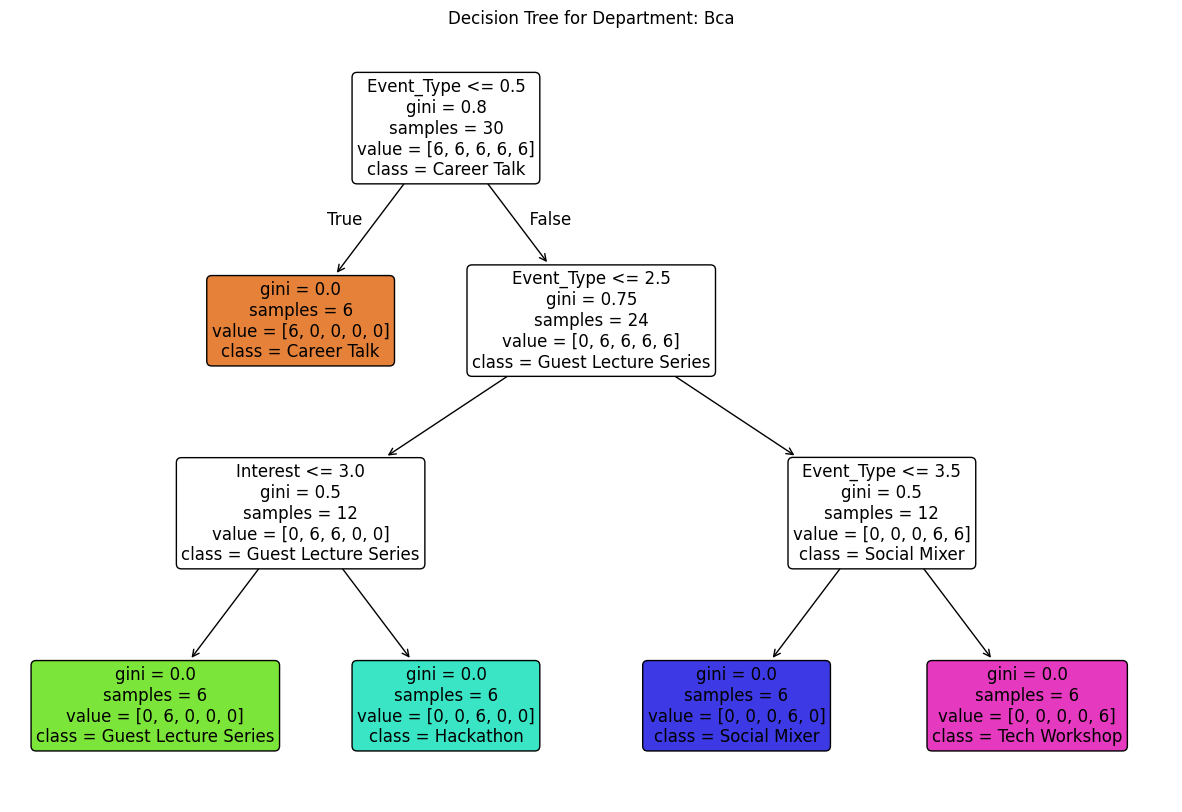

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=label_encoders['Target_Event'].classes_,
    filled=True,
    rounded=True,
    fontsize=12
)
plt.title(f"Decision Tree for Department: {dept}")
plt.show()